# Take Home Project - Job Posting Duplication Detection

Goal: Identify duplicate job postings using a job posting dataset and apply NLP techniques to detect similarities. 

## 1. Open the data

In [1]:
import pandas as pd

# Load the data
df = pd.read_csv('jobs.csv.zip')
print(df.head())

                                      jobTitle        companyName  \
0  Nuclear Medicine Tech, Full Time, Day Shift   Adventist Health   
1          Radiation Therapist - SIGN-ON BONUS  SkinCure Oncology   
2            Delivery Driver - Earn Extra Cash           DoorDash   
3                                    Paramedic                AMR   
4        Sales Lead - White House Black Market            Chico's   

                                lid  \
0  07213bcc5db0efec311b1884459defed   
1  53994c1a47063a39ed3bf5509c0d6676   
2  22ea5183b183b0ba1999b465cddc0364   
3  9255fae6f210f0ca9fdda3c32b99fc1e   
4  362836240b3a6ad18c342d840f569622   

                                          jobDescRaw finalZipcode finalState  \
0  <div class="normalText"><p>Job Description</p>...        93465        CA,   
1  <div class="normalText"><p>Seeking Radiation T...        47802        IN,   
2  <div class="-desktop-no-padding-top" id="job-d...        46403         IN   
3  <div class="-desktop-no-pad

## 2. Data Exploration

In [5]:
# Data Inspection

# Check the shape of the dataset
print("Dataset Shape:", df.shape)

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Clean HTML tags from jobDescRaw and calculate description lengths
df['jobDescCleaned'] = df['jobDescRaw'].str.replace(r'<[^>]+>', '', regex=True)  # Remove HTML tags
df['jobDescCleaned'] = df['jobDescCleaned'].str.replace(r'[^a-zA-Z\s]', '', regex=True)  # Keep only letters and spaces
df['description_length'] = df['jobDescCleaned'].apply(lambda x: len(str(x).split()))
print("Average Description Length (words):", df['description_length'].mean())
print("Min Description Length:", df['description_length'].min())
print("Max Description Length:", df['description_length'].max())

# Distribution of job titles, states, and seniority
print("Top 5 Job Titles:\n", df['jobTitle'].value_counts().head())
print("Top 5 States:\n", df['finalState'].value_counts().head())
print("Seniority Levels:\n", df['nlpSeniority'].value_counts())

Dataset Shape: (100000, 17)
Missing Values:
 jobTitle                0
companyName           325
lid                     0
jobDescRaw              0
finalZipcode         2051
finalState           1420
finalCity            1795
companyBranchName     325
jobDescUrl              0
nlpBenefits             0
nlpSkills               0
nlpSoftSkills           0
nlpDegreeLevel          0
nlpEmployment           0
nlpSeniority            0
correctDate            14
scrapedLocation         0
dtype: int64
Average Description Length (words): 471.27361
Min Description Length: 0
Max Description Length: 4530
Top 5 Job Titles:
 jobTitle
Delivery Driver                           736
Delivery Driver - No Experience Needed    651
Drive with DoorDash                       645
Licensed Psychologist                     622
Delivery Driver - Earn Extra Cash         609
Name: count, dtype: int64
Top 5 States:
 finalState
CA     5188
TX     4315
FL     3568
CA,    3093
NY     3017
Name: count, dtype: int64
Sen

In [6]:
# Data Cleaning

# Clean HTML tags and special characters from jobDescRaw
df['jobDescCleaned'] = df['jobDescRaw'].str.replace(r'<[^>]+>', '', regex=True)  # Remove HTML tags
df['jobDescCleaned'] = df['jobDescCleaned'].str.replace(r'[^a-zA-Z\s]', '', regex=True)  # Keep only letters and spaces

# Recalculate description lengths
df['description_length'] = df['jobDescCleaned'].apply(lambda x: len(str(x).split()))

# Remove rows with no descriptions
df = df[df['description_length'] > 0]

# Clean finalState column
df['finalState'] = df['finalState'].str.replace(r',\s*$', '', regex=True)

# Truncate long descriptions to 1,000 words
df['jobDescCleaned'] = df['jobDescCleaned'].apply(lambda x: ' '.join(str(x).split()[:1000]))

/var/folders/gv/l2x3hd0s207dvl6x_ttggkgr0000gr/T/ipykernel_93318/3547551447.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['finalState'] = df['finalState'].str.replace(r',\s*$', '', regex=True)
/var/folders/gv/l2x3hd0s207dvl6x_ttggkgr0000gr/T/ipykernel_93318/3547551447.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['jobDescCleaned'] = df['jobDescCleaned'].apply(lambda x: ' '.join(str(x).split()[:1000]))


## 3: Generate Embeddings with Sentence-Transformers, GloVe, and spaCy

Use sentence-transformers, GloVe, CBOW, and spaCy to generate embeddings for the job descriptions. I’ll use sentence-transformers as the primary method because of its effectiveness for semantic similarity tasks, and I’ll also implement GloVe (via gensim) and spaCy for comparison. I’ll skip CBOW for now since it’s a training method for Word2Vec (similar to GloVe), requires training a custom model. There does seem to be a lot of variety across the jobs, so if the results are not satisfying for the training method I use for the embeddings, I will explore a custom model. 

### Step 1: Generate Embeddings with Sentence-Transformers

In [7]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained model, the all-MiniLM-L6-v2 model produces 384-dimensional 
# embeddings that capture contextual meaning across the entire description
model = SentenceTransformer('all-MiniLM-L6-v2')

#The batch_size=32 parameter helps manage memory usage for a large dataset (99,992 rows).
embeddings = model.encode(df['jobDescCleaned'].tolist(), show_progress_bar=True, batch_size=32)

# Add embeddings to the dataframe
df['embeddings'] = list(embeddings)

# Save the updated dataframe to a new CSV file
df.to_csv('jobs_with_sentence_embeddings.csv', index=False)

print("Embeddings saved successfully!")

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

Embeddings saved successfully!


### Step 2: Generate Embeddings with GloVe

GloVe embeddings are static word embeddings, so we’ll need to average the embeddings of individual words in each job description to get a single vector per description. I’ll use the gensim library to load pre-trained GloVe embeddings.

In [8]:
import numpy as np
from gensim.downloader import load

# Load pre-trained GloVe embeddings, glove-wiki-gigaword-300 provides 300-dimensional 
# embeddings trained on Wikipedia and Gigaword.
glove_model = load('glove-wiki-gigaword-300')

# Function to compute average GloVe embedding for a description
# Averaging word embeddings is a simple way to get a single vector per description, 
# but it may lose some contextual information compared to sentence-transformers.
def get_glove_embedding(text):
    words = text.split()
    word_vectors = [glove_model[word] for word in words if word in glove_model]
    if not word_vectors:  # If no words are in the vocabulary, return a zero vector
        return np.zeros(300)
    return np.mean(word_vectors, axis=0)

# Generate GloVe embeddings for job descriptions
df['glove_embeddings'] = df['jobDescCleaned'].apply(get_glove_embedding)

df.to_csv('jobs_with_glove_embeddings.csv', index=False)

### Step 3 Generate Embeddings with spaCy

In [ ]:
import spacy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm  # Auto works best across Jupyter & scripts

# !python -m spacy download en_core_web_lg

# Load spaCy's large English model with word vectors
# en_core_web_lg provides 300-dimensional embeddings by averaging the token vectors in the description.
# Like GloVe, this method may lose some contextual nuance compared to sentence-transformers. Speed is also slower.
nlp = spacy.load('en_core_web_lg', disable=["parser", "ner"])

# Ensure no NaN values in the column
df['jobDescCleaned'] = df['jobDescCleaned'].fillna("")

# Enable tqdm progress bar for spaCy's pipe()
tqdm.pandas(desc="Processing job descriptions")

# Process in batches using pipe() to speed up the progress
def generate_embeddings(texts):
    return np.array([doc.vector for doc in tqdm(nlp.pipe(texts, batch_size=256, n_process=4), total=len(texts), desc="Generating embeddings", dynamic_ncols=True)])

# Generate embeddings with progress bar
df['spacy_embeddings'] = list(generate_embeddings(df['jobDescCleaned'].tolist()))

# Save to file
df.to_csv('jobs_with_spacy_embeddings.csv', index=False)

print("Embeddings saved successfully!")

Comparison:

* Sentence-Transformers: 384-dimensional, contextual embeddings that capture the full meaning of the description.
* GloVe: 300-dimensional, static embeddings averaged over words, less context-aware.
* spaCy: 300-dimensional, averaged token embeddings, similar to GloVe but with spaCy’s tokenization and vector space.

## 4. Vector Search

I’ll implement a vector search system to find similar job descriptions using the embeddings. Given the large dataset (99,992 rows), I’ll use faiss for efficient similarity search, as it’s more scalable than computing cosine similarity for every query.

Implementation with FAISS:

Enter job title to search:  Delivery Driver
Enter the number of similar jobs to retrieve:  10



Processing GloVe embeddings...


Parsing embeddings (jobs_with_glove_embeddings.csv): 100%|█| 99992/99992 [00:06<
Adding embeddings to FAISS: 100%|████| 99992/99992 [00:00<00:00, 1548395.46it/s]


Similar jobs found for GloVe:
Job ID                              Job Title                                Company Name                             Similarity Score    
---------------------------------------------------------------------------------------------------------------------------------------
d81838db03b3eb92afe0022d37b62c28    Delivery Driver - No Experience Needed   DoorDash                                 0.9996              
4b29e43947b9ec686402ab87d954a4f2    Delivery Driver                          DoorDash                                 0.9996              
6a95870e59ad8909d2daa62e06725dc5    Restaurant Delivery                      DoorDash                                 0.9996              
bfbd1e7a19cecea9516f7eef737d9dc1    Delivery Driver - No Experience Needed   DoorDash                                 0.9996              
693d86972e06012e89f1dc49aac51179    Restaurant Delivery                      DoorDash                                 0.9996              


Parsing embeddings (jobs_with_spacy_embeddings.csv): 100%|█| 99992/99992 [00:06<
Adding embeddings to FAISS: 100%|████| 99992/99992 [00:00<00:00, 2333976.17it/s]


Similar jobs found for SpaCy:
Job ID                              Job Title                                Company Name                             Similarity Score    
---------------------------------------------------------------------------------------------------------------------------------------
85d414afe0036b8f94e57e78ed468526    Delivery Driver                          DoorDash                                 0.9997              
1877c88be826c6e301bd7895a1314af6    Delivery Driver                          DoorDash                                 0.9997              
be537722a76ea2a66a96925f0e7207d7    Delivery Driver                          DoorDash                                 0.9997              
a96e7dffa00840e8a444cff717301c8f    Delivery Driver                          DoorDash                                 0.9996              
6f014f67bec8fd1989cf9cecf21ad987    Delivery Driver - Sign Up and Start Earning DoorDash                                 0.9996            

Parsing embeddings (jobs_with_sentence_embeddings.csv): 100%|█| 99992/99992 [00:
Adding embeddings to FAISS: 100%|████| 99992/99992 [00:00<00:00, 2322524.59it/s]


Similar jobs found for Sentence-Transformers:
Job ID                              Job Title                                Company Name                             Similarity Score    
---------------------------------------------------------------------------------------------------------------------------------------
5d24476af0d83d26b9da971871ea4566    Delivery Driver                          DoorDash                                 0.9942              
0a61710c1fb5764a37005043b9e50939    Delivery Driver                          DoorDash                                 0.9942              
1ad0408836fa64846585fec4ed581cca    Delivery Driver                          DoorDash                                 0.9939              
1a7c932d0da843f859509288924b4a9e    Delivery Driver                          DoorDash                                 0.9939              
262f85b0cce80fbec1faf9ac2878ee23    Delivery Driver                          DoorDash                                 0.993

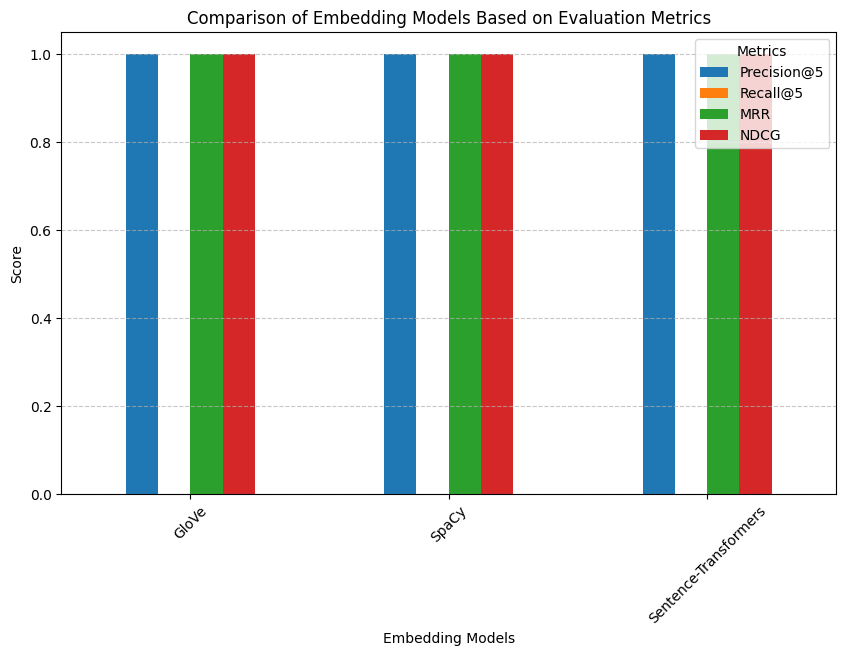


Best performing model based on evaluation metrics: GloVe


In [17]:
import numpy as np
import faiss
import ast
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score

class JobEmbeddingSearch:
    def __init__(self, embedding_files):
        self.embedding_files = embedding_files
        self.results = defaultdict(dict)
        self.eval_df = None
    
    def load_and_process_embeddings(self, file_path, column_name):
        df = pd.read_csv(file_path)
        # Inspect the format of the embeddings
        
        # Updated parsing method to handle different formats
        def parse_embedding(embedding_str):
            try:
                # First, try ast.literal_eval (handles formats like '[0.1, 0.2, 0.3]')
                embedding_list = ast.literal_eval(embedding_str)
                return np.array(embedding_list, dtype=np.float32)
            except:
                try:
                    # Fallback: strip brackets and split (handles formats like '[0.1 0.2 0.3]')
                    embedding_list = [float(x) for x in embedding_str.strip('[]').split()]
                    return np.array(embedding_list, dtype=np.float32)
                except Exception as e:
                    # Return a zero vector of the correct size (384 for Sentence-Transformers, 300 for GloVe and spaCy)
                    return np.zeros(384 if 'sentence' in file_path.lower() else 300, dtype=np.float32)

        # Apply parsing with progress bar
        tqdm.pandas(desc=f"Parsing embeddings ({file_path})")
        df[column_name] = df[column_name].progress_apply(parse_embedding)
        
        # Convert to embedding matrix
        embedding_matrix = np.vstack(df[column_name])
        
        # Check for zero vectors
        zero_vectors = np.all(embedding_matrix == 0, axis=1).sum()

        # Normalize for cosine similarity
        faiss.normalize_L2(embedding_matrix)
        
        # Check norms after normalization
        norms = np.linalg.norm(embedding_matrix, axis=1)

        return df, embedding_matrix

    def build_faiss_index(self, embedding_matrix):
        d = embedding_matrix.shape[1]
        # Use IndexIVFFlat for faster search
        nlist = 100  # Number of clusters
        quantizer = faiss.IndexFlatIP(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
        
        # Train the index
        index.train(embedding_matrix)
        
        # Add embeddings with progress bar
        with tqdm(total=embedding_matrix.shape[0], desc="Adding embeddings to FAISS") as pbar:
            index.add(embedding_matrix)
            pbar.update(embedding_matrix.shape[0])
        
        index.nprobe = 10  # Number of clusters to probe
        return index

    def find_similar_jobs(self, job_title, df, embedding_matrix, faiss_index, top_k):
        query_idx = df[df['jobTitle'] == job_title].index
        if query_idx.empty:
            print(f"Job title '{job_title}' not found in dataset.")
            return None, None
        query_idx = query_idx[0]
        query_embedding = embedding_matrix[query_idx].reshape(1, -1)
        if np.all(query_embedding == 0):
            print("Warning: Query embedding is a zero vector!")
        distances, indices = faiss_index.search(query_embedding, top_k + 1)
        similar_indices = indices[0][1:]
        return df.iloc[similar_indices], distances[0][1:]

    def compute_metrics(self, job_title, similar_jobs, similarities, df, top_k):
        # Define relevant jobs (ground truth) based on job title keywords
        query_keywords = set(job_title.lower().split())
        relevant_jobs = df[df['jobTitle'].str.lower().apply(
            lambda x: any(keyword in x for keyword in query_keywords if len(keyword) > 3)
        )].index.tolist()
        
        # Get indices of retrieved jobs
        retrieved_indices = similar_jobs.index.tolist()
        
        # Precision@5: Fraction of retrieved jobs that are relevant
        relevant_retrieved = len(set(retrieved_indices[:5]).intersection(relevant_jobs))
        precision_at_5 = relevant_retrieved / 5 if len(retrieved_indices) >= 5 else 0
        
        # Recall@5: Fraction of relevant jobs that were retrieved
        recall_at_5 = relevant_retrieved / len(relevant_jobs) if len(relevant_jobs) > 0 else 0
        
        # MRR: Mean Reciprocal Rank
        mrr = 0
        for rank, idx in enumerate(retrieved_indices, 1):
            if idx in relevant_jobs:
                mrr = 1 / rank
                break
        
        # NDCG@5: Normalized Discounted Cumulative Gain
        true_relevance = [1 if idx in relevant_jobs else 0 for idx in retrieved_indices[:5]]
        if len(true_relevance) < 5:
            true_relevance.extend([0] * (5 - len(true_relevance)))
        ideal_relevance = sorted(true_relevance, reverse=True)
        ndcg = ndcg_score([ideal_relevance], [true_relevance]) if sum(true_relevance) > 0 else 0
        
        return {
            'Precision@5': precision_at_5,
            'Recall@5': recall_at_5,
            'MRR': mrr,
            'NDCG': ndcg
        }

    def run_search(self, job_title):
        top_k = int(input("Enter the number of similar jobs to retrieve: "))
        
        # Define domain keywords based on the job title
        query_keywords = job_title.lower().split()
        domain_keywords = query_keywords + ["research", "lab", "science", "tech"]  # General domain keywords
        
        for model, (file_path, column_name) in self.embedding_files.items():
            print(f"\nProcessing {model} embeddings...")
            df, embedding_matrix = self.load_and_process_embeddings(file_path, column_name)
            index = self.build_faiss_index(embedding_matrix)
            similar_jobs, similarities = self.find_similar_jobs(job_title, df, embedding_matrix, index, top_k=top_k)
            
            if similar_jobs is not None:
                self.results[model]['similar_jobs'] = similar_jobs
                self.results[model]['similarities'] = similarities
                
                # Compute evaluation metrics
                metrics = self.compute_metrics(job_title, similar_jobs, similarities, df, top_k)
                for metric, value in metrics.items():
                    self.results[model][metric] = value
                
                print(f"Similar jobs found for {model}:")
                print(f"{'Job ID':<35} {'Job Title':<40} {'Company Name':<40} {'Similarity Score':<20}")
                print("-" * 135)
                
                for idx, row in similar_jobs.iterrows():
                    job_id = row['lid']
                    job_title_display = row['jobTitle']
                    company_name = row['companyName']
                    similarity_score = similarities[similar_jobs.index.get_loc(idx)]
                    
                    # Check if the job title or description contains domain keywords
                    job_desc = row.get('jobDescCleaned', '')
                    if any(keyword.lower() in job_title_display.lower() or keyword.lower() in job_desc.lower() 
                           for keyword in domain_keywords):
                        print(f"{job_id:<35} {job_title_display:<40} {company_name:<40} {similarity_score:<20.4f}")
        
        # Create evaluation DataFrame
        metrics = ['Precision@5', 'Recall@5', 'MRR', 'NDCG']
        self.eval_df = pd.DataFrame.from_dict(
            {model: [results[metric] for metric in metrics] for model, results in self.results.items()},
            orient='index',
            columns=metrics
        )
        print("\nEvaluation Metrics:")
        print(self.eval_df)

    def plot_results(self):
        if self.eval_df is None:
            print("No evaluation data available. Run search first.")
            return
        
        self.eval_df.plot(kind='bar', figsize=(10, 6))
        plt.title("Comparison of Embedding Models Based on Evaluation Metrics")
        plt.ylabel("Score")
        plt.xlabel("Embedding Models")
        plt.xticks(rotation=45)
        plt.legend(title="Metrics")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    
    def best_model(self):
        if self.eval_df is None:
            print("No evaluation data available. Run search first.")
            return
        
        self.eval_df['Average Score'] = self.eval_df.mean(axis=1)
        best_model = self.eval_df['Average Score'].idxmax()
        print(f"\nBest performing model based on evaluation metrics: {best_model}")

# Define file paths and embedding column names
embedding_files = {
    'GloVe': ('jobs_with_glove_embeddings.csv', 'glove_embeddings'),
    'SpaCy': ('jobs_with_spacy_embeddings.csv', 'spacy_embeddings'),
    'Sentence-Transformers': ('jobs_with_sentence_embeddings.csv', 'embeddings')
}

# Initialize the class and run search
job_search = JobEmbeddingSearch(embedding_files)
user_input_job = input("Enter job title to search: ")
job_search.run_search(user_input_job)

# Plot results only if the search returned results
if job_search.results:
    job_search.plot_results()
job_search.best_model()

In [85]:
df['jobTitle'][0:6]

0    Nuclear Medicine Tech, Full Time, Day Shift
1            Radiation Therapist - SIGN-ON BONUS
2              Delivery Driver - Earn Extra Cash
3                                      Paramedic
4          Sales Lead - White House Black Market
5              Fabrication Associate - Assembler
Name: jobTitle, dtype: object